In [1]:
% matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.metrics import r2_score
import shapefile
import shapely.geometry as sgeom
from jenkspy import jenks_breaks
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import rgb2hex
import cartopy.feature as cfeature
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
import cartopy.io.shapereader as shpreader
from descartes import PolygonPatch
from shapely.geometry import Polygon

In [3]:
sns.set_style("ticks")
sns.set_palette(sns.color_palette("dark", 8))
plt_colors = sns.color_palette()
mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams.update({'font.size': 12})

In [4]:
baselines_df = pd.read_csv("../baselines/baseline_results.csv")

In [25]:
frac = ""

In [26]:
fold_results = []
for i in range(1, 5 + 1):
  fold_data = pd.read_csv("../data/fold_%d/test.csv" % i)
  mu = np.load("../data/fold_%d/mu.npy" % i)
  std = np.load("../data/fold_%d/std.npy" % i)
  true = np.load("./fold_%d%s/y_true.npy" % (i, frac))
  l8 = np.load("./fold_%d%s/y_pred_l8.npy" % (i, frac))
  s1 = np.load("./fold_%d%s/y_pred_s1.npy" % (i, frac))
  
  baselines_df.loc[baselines_df["fold"] == i,"gbm"] = baselines_df.loc[baselines_df["fold"] == i,"gbm"] * std + mu
  baselines_df.loc[baselines_df["fold"] == i,"knn"] = baselines_df.loc[baselines_df["fold"] == i,"knn"] * std + mu
  baselines_df.loc[baselines_df["fold"] == i,"ridge"] = baselines_df.loc[baselines_df["fold"] == i,"ridge"] * std + mu
  baselines_df.loc[baselines_df["fold"] == i,"true"] = baselines_df.loc[baselines_df["fold"] == i,"true"] * std + mu
  
  fold_results.append(pd.DataFrame({
    "true": true * std + mu,
    "l8": l8 * std + mu,
    "s1": s1 * std + mu,
    "pred": np.average((l8 * std + mu, s1 * std + mu), axis=0, weights=[0.5, 0.5]),
    "state_idx": fold_data["state_idx"],
    "district_idx": fold_data["district_idx"],
    "taluk_idx": fold_data["taluk_idx"],
    "lat": fold_data["latitude"],
    "lng": fold_data["longitude"],
    "fold": i,
  }))

In [27]:
test_df = pd.concat(fold_results)

In [28]:
test_df = test_df.reset_index()

In [29]:
test_df.to_csv("./test_results%s.csv" % frac)

In [30]:
knn = KNeighborsRegressor(n_neighbors=30)

In [31]:
knn.fit(test_df[["lat", "lng"]], test_df["pred"])

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=30, p=2,
          weights='uniform')

In [32]:
test_df["smoothed"] = knn.predict(test_df[["lat", "lng"]])

In [33]:
print("Pred: %.3f" % r2_score(test_df["true"], test_df["smoothed"]))

Pred: 0.285


In [34]:
# test_df["knn"] = baselines_df["knn"]
test_df["gbm"] = baselines_df["gbm"]
# test_df["smoothed"] = 0.5 * test_df["pred"] + 0.5 * test_df["knn"]

In [35]:
# print("L8/S1 correlation: %.3f" % test_df["l8"].corr(test_df["s1"]))
# print("KNN/Prediction correlation: %.3f" % test_df["knn"].corr(test_df["pred"]))

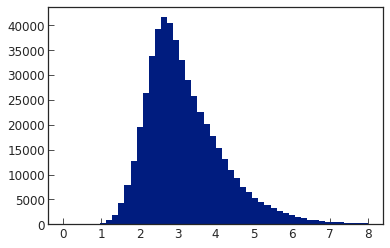

In [36]:
# histogram in $/day
plt.hist((test_df["true"] / 365.25 / 16.013)[test_df["true"] / 365.25 / 16.013 < 8], bins=50);

In [37]:
print("Percent 3 SD outliers: %.4f" % (1-np.mean((test_df["true"] - np.mean(test_df["true"])) / np.std(test_df["true"]) < 3)))

Percent 3 SD outliers: 0.0103


In [38]:
print("Pred: %.3f" % r2_score(test_df["true"], test_df["pred"]))
# print("KNN: %.3f" % r2_score(test_df["true"], test_df["knn"]))
print("Smoothed pred: %.3f" % r2_score(test_df["true"], test_df["smoothed"]))
print("Outliers: %.3f" % r2_score(test_df["true"][(test_df["true"] - np.mean(test_df["true"])) / np.std(test_df["true"]) < 3],
                                  test_df["pred"][(test_df["true"] - np.mean(test_df["true"])) / np.std(test_df["true"]) < 3]))
print("Outliers smoothed: %.3f" % r2_score(test_df["true"][(test_df["true"] - np.mean(test_df["true"])) / np.std(test_df["true"]) < 3],
                                  test_df["smoothed"][(test_df["true"] - np.mean(test_df["true"])) / np.std(test_df["true"]) < 3]))
print("L8: %.3f" % r2_score(test_df["true"], test_df["l8"]))
print("S1: %.3f" % r2_score(test_df["true"], test_df["s1"]))

Pred: 0.258
Smoothed pred: 0.285
Outliers: 0.351
Outliers smoothed: 0.393
L8: 0.223
S1: 0.196


In [39]:
# https://data.oecd.org/conversion/purchasing-power-parities-ppp.htm
test_df["true"] = test_df["true"] / 365.25 / 16.013
test_df["smoothed"] = test_df["smoothed"] / 365.25 / 16.013
test_df["gbm"] = test_df["gbm"] / 365.25 / 16.013

In [40]:
# sanity check
r2_score(test_df["true"], test_df["smoothed"])

0.2845193360762096

In [41]:
pctles = []
r2s_smoothed = []
r2s_gbm = []
for pctle in np.arange(5, 101, 5):
  cutoff = np.percentile(test_df["true"], q=pctle)
  pctles.append(pctle)
  r2s_smoothed.append((test_df["true"][test_df["true"] < cutoff].corr(test_df["smoothed"][test_df["true"] < cutoff])) ** 2)
  r2s_gbm.append((test_df["true"][test_df["true"] < cutoff].corr(test_df["gbm"][test_df["true"] < cutoff])) ** 2)

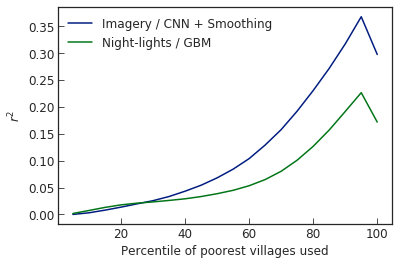

In [42]:
plt.plot(pctles, r2s_smoothed, label="Imagery / CNN + Smoothing")
plt.plot(pctles, r2s_gbm, label="Night-lights / GBM")
plt.xlabel("Percentile of poorest villages used")
plt.ylabel("$r^2$")
plt.legend();

In [43]:
preds = {
  "district": test_df.groupby("district_idx")["smoothed"].mean(),
  "taluk": test_df.groupby("taluk_idx")["smoothed"].mean(),
}
trues = {
  "district": test_df.groupby("district_idx")["true"].mean(),
  "taluk": test_df.groupby("taluk_idx")["true"].mean(),
}

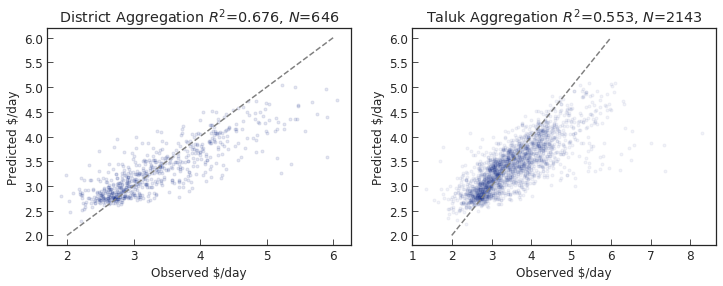

In [44]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.scatter(trues["district"], preds["district"],
            marker=".", alpha=0.1)
plt.plot((2,6), (2,6), "--", color="grey")
plt.xlabel("Observed $/day")
plt.ylabel("Predicted $/day")
r2 = r2_score(trues["district"], preds["district"])
plt.title("District Aggregation $R^2$=%.3f, $N$=%d" % (r2, len(trues["district"])))
plt.subplot(1,2,2)
plt.scatter(trues["taluk"], preds["taluk"],
            marker=".", alpha=0.05)
plt.plot((2,6), (2,6), "--", color="grey")
plt.xlabel("Observed $/day")
plt.ylabel("Predicted $/day")
r2 = r2_score(trues["taluk"], preds["taluk"])
plt.title("Taluk Aggregation $R^2$=%.3f, $N$=%d" % (r2, len(trues["taluk"])));

In [48]:
district_shapes = shapefile.Reader("../data/india_shape_files/IND_adm2").shapes()
district_points = [shape.points for shape in district_shapes]
district_polygons = [Polygon(p) for p in district_points]

In [49]:
taluk_shapes = shapefile.Reader("../data/india_shape_files/IND_adm3").shapes()
taluk_points = [shape.points for shape in taluk_shapes]
taluk_polygons = [Polygon(p) for p in taluk_points]

In [50]:
taluk_areas = [p.area for p in taluk_polygons]

In [51]:
np.percentile(taluk_areas, [2.5, 50, 97.5])

array([0.00390405, 0.09218818, 0.3959341 ])

In [52]:
polygons = {
  "district": district_polygons, 
  "taluk": taluk_polygons
}

In [53]:
bins = jenks_breaks(np.r_[trues["taluk"].values, preds["taluk"].values], nb_class=4)

In [54]:
heatmap_colors = sns.color_palette("hot", 5)[::-1]

In [55]:
def plot_true_vs_pred(division_level):

  fig = plt.figure(figsize=(14, 8))

  countries = cfeature.NaturalEarthFeature(
      category='cultural',
      name='admin_0_countries',
      scale='50m',
      facecolor='none')

  ax = plt.subplot(1,2,1, projection=ccrs.PlateCarree())
  ax.add_feature(countries, edgecolor="black")
  ax.add_feature(cfeature.OCEAN, zorder=0)
  ax.add_feature(cfeature.LAND, zorder=0)
  ax.set_extent([67, 98, 7.5, 36])
  
  colors = np.digitize(preds[division_level] - 1e-4, bins)
  for i, color in zip(preds[division_level].keys(), colors):
    polygon = polygons[division_level][i]
    poly = PolygonPatch(polygon, facecolor=rgb2hex(heatmap_colors[color]),
                        edgecolor="black")
    ax.add_patch(poly)
  plt.bar((-1), (-1), color=heatmap_colors[0], label="< %.2f" % bins[0])
  plt.bar((-1), (-1), color=heatmap_colors[1], label="%.2f - %.2f" % (bins[0], bins[1]))
  plt.bar((-1), (-1), color=heatmap_colors[2], label="%.2f - %.2f" % (bins[1], bins[2]))
  plt.bar((-1), (-1), color=heatmap_colors[3], label="%.2f - %.2f" % (bins[2], bins[3]))
  plt.bar((-1), (-1), color=heatmap_colors[4], label="> %.2f" % bins[3])
  ax.legend()
  plt.title("Predicted", fontweight="bold", fontsize=12)

  ax = plt.subplot(1,2,2, projection=ccrs.PlateCarree())
  ax.add_feature(countries, edgecolor="black")
  ax.add_feature(cfeature.OCEAN, zorder=0)
  ax.add_feature(cfeature.LAND, zorder=0)
  ax.set_extent([67, 98, 7.5, 36])
  
  colors = np.digitize(trues[division_level] - 1e-4, bins)
  for i, color in zip(trues[division_level].keys(), colors):
    polygon = polygons[division_level][i]
    poly = PolygonPatch(polygon, facecolor=rgb2hex(heatmap_colors[color]),
                        edgecolor="black")
    ax.add_patch(poly)
  plt.bar((-1), (-1), color=heatmap_colors[0], label="< %.2f" % bins[0])
  plt.bar((-1), (-1), color=heatmap_colors[1], label="%.2f - %.2f" % (bins[0], bins[1]))
  plt.bar((-1), (-1), color=heatmap_colors[2], label="%.2f - %.2f" % (bins[1], bins[2]))
  plt.bar((-1), (-1), color=heatmap_colors[3], label="%.2f - %.2f" % (bins[2], bins[3]))
  plt.bar((-1), (-1), color=heatmap_colors[4], label="> %.2f" % bins[3])
  ax.legend()
  plt.title("Actual", fontweight="bold", fontsize=12)

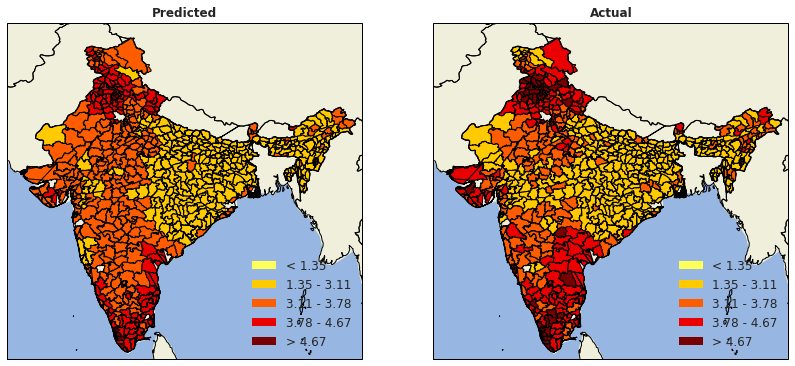

In [56]:
plot_true_vs_pred("district")

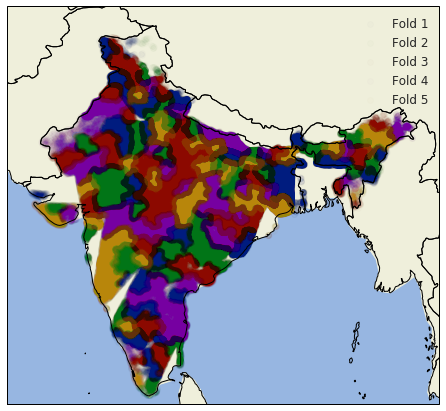

In [252]:
plt.figure(figsize=(6, 8))
ax = plt.axes([0, 0, 1, 1], projection=ccrs.PlateCarree())
ax.set_extent([67, 99, 7.5, 36])
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_countries',
    scale='50m',
    facecolor='none')
for i in range(1, 5 + 1):
  plt.scatter(test_df["lng"][test_df["fold"] == i], 
              test_df["lat"][test_df["fold"] == i], 
              label="Fold %d" % i, alpha=0.01)
ax.add_feature(states_provinces, edgecolor="black")
ax.add_feature(cfeature.OCEAN, zorder=0)
ax.add_feature(cfeature.LAND, zorder=0)
plt.legend()

In [57]:
def plot_diffs(division_level):
  
  plt.figure(figsize=(6, 8))
  
  ax = plt.axes([0, 0, 1, 1], projection=ccrs.PlateCarree())
  ax.set_extent([67, 99, 7.5, 36])

  states_provinces = cfeature.NaturalEarthFeature(
      category='cultural',
      name='admin_0_countries',
      scale='50m',
      facecolor='none')

  cmap = plt.cm.hot
  values = np.abs(preds[division_level] - trues[division_level])
  vmin = np.min(values)
  vmax = np.max(values)

  for i, polygon in enumerate(polygons[division_level]):
    if i in values:
      color = rgb2hex(cmap(1-np.sqrt((values[i]-vmin)/(vmax-vmin))))
      poly = PolygonPatch(polygon, facecolor=color, edgecolor="black")
      ax.add_patch(poly)

  ax.add_feature(states_provinces, edgecolor="black")
  ax.add_feature(cfeature.OCEAN, zorder=0)
  ax.add_feature(cfeature.LAND, zorder=0)

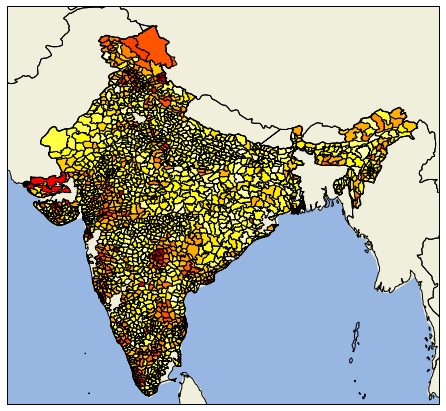

In [59]:
plot_diffs("taluk")

In [61]:
india_processed = pd.read_csv("../data/india_processed.csv")

In [104]:
india_processed["secc_cons_per_cap_scaled"].sample(15)

36664     28422.765625
387504    10231.619141
195188    13288.622070
378808    17971.001953
380214    15589.056641
407968    15850.556641
410429    22752.904297
154613    16347.344727
233623    16111.623047
184421    14863.379883
384313    18555.400391
395992    13876.429688
428597    14167.933594
450397    18993.666016
373900    15730.314453
Name: secc_cons_per_cap_scaled, dtype: float64

In [105]:
row = india_processed.iloc[36664,]

In [115]:
import cv2

In [124]:
from PIL import Image

In [127]:
img = Image.open("../../imagery/" + row["l8_path"])

In [ ]:
img.crop(())

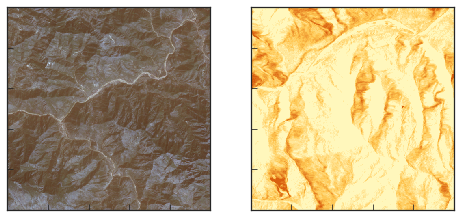

In [120]:
plt.figure(figsize=(8, 4))
ax = plt.subplot(1,2,1)
plt.imshow(cv2.imread("../../imagery/" + row["l8_path"]))
ax.set_xticklabels(())
ax.set_yticklabels(())
ax = plt.subplot(1,2,2)
plt.imshow(plt.imread("../../imagery/" + row["s1_path"]))
ax.set_xticklabels(())
ax.set_yticklabels(());

In [83]:
bangladesh_df = pd.read_csv("../data/bangladesh_test.csv")

In [92]:
bangladesh_df["l8"] = np.load("./bangladesh/y_pred_l8.npy")
bangladesh_df["s1"] = np.load("./bangladesh/y_pred_s1.npy")
bangladesh_df["pred"] = np.mean((bangladesh_df["s1"], bangladesh_df["l8"]), axis=0)

In [102]:
def calculate_concordance(trues, preds):
  concordance, N = 0, len(trues)
  counter = 0
  for i in range(N):
    for j in range(i + 1, N):
      if (preds[i] < preds[j] and trues[i] < trues[j]) or \
         (preds[i] > preds[j] and trues[i] > trues[j]):
          concordance += 1
      elif preds[i] == preds[j]:
        concordance += 0.5
      counter += 1
  return concordance / counter

In [103]:
calculate_concordance(bangladesh_df["totexp_m_pc"], bangladesh_df["pred"])

0.5014020707506471

In [104]:
train = pd.read_csv("../data/fold_1/train.csv")
valid = pd.read_csv("../data/fold_1/valid.csv")
test = pd.read_csv("../data/fold_1/test.csv")

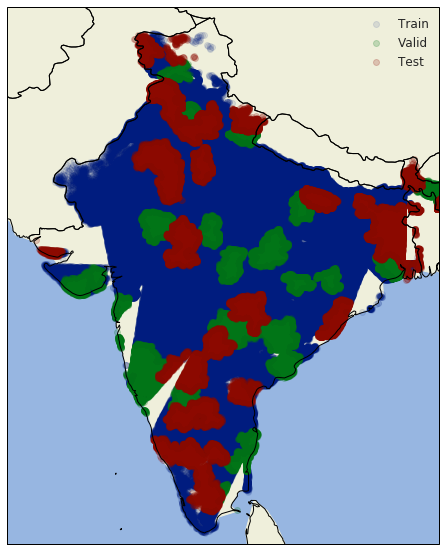

In [111]:
plt.figure(figsize=(6, 8))
ax = plt.axes([0, 0, 1, 1], projection=ccrs.PlateCarree())
ax.set_extent([67, 90, 7.5, 36])
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_countries',
    scale='50m',
    facecolor='none')
plt.scatter(train["longitude"],
            train["latitude"],
            label="Train", alpha=0.1)
plt.scatter(valid["longitude"],
            valid["latitude"],
            label="Valid", alpha=0.2)
plt.scatter(test["longitude"],
            test["latitude"],
            label="Test", alpha=0.2)
ax.add_feature(states_provinces, edgecolor="black")
ax.add_feature(cfeature.OCEAN, zorder=0)
ax.add_feature(cfeature.LAND, zorder=0)
plt.legend()